In [2]:
import json
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich import box
import time
import hashlib
import hmac
import requests
import json

In [ ]:
import requests

def get_ticker_price(pair):
    url = f"https://api.gate.io/api2/1/ticker/{pair}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return {
            'last': data['last'],  # Last trade price
            'lowestAsk': data['lowestAsk'],  # Lowest ask price
            'highestBid': data['highestBid'],  # Highest bid price
            'percentChange': data['percentChange'],  # Percentage change in 24 hours
            'baseVolume': data['baseVolume'],  # Volume of base currency traded in 24 hours
            'quoteVolume': data['quoteVolume'],  # Volume of quote currency traded in 24 hours
            'high24hr': data['high24hr'],  # Highest price in the last 24 hours
            'low24hr': data['low24hr']  # Lowest price in the last 24 hours
        }
    else:
        return {'error': 'Failed to fetch data'}

# Pairs to fetch
pairs = ['btc_usdt', 'eth_usdt', 'doge_usdt']

# Fetch and print data for each pair
for pair in pairs:
    price_info = get_ticker_price(pair)
    print(f"Data for {pair.upper()}: {price_info}")


In [ ]:
import requests

def get_top_volume_pairs(n=10):
    url = "https://api.gate.io/api2/1/tickers"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        # Create a list of pairs with their volumes, and convert volumes to floats for sorting
        volumes = [(pair, float(details['baseVolume'])) for pair, details in data.items()]
        # Sort by volume in descending order
        top_volumes = sorted(volumes, key=lambda x: x[1], reverse=True)
        return top_volumes[:n]
    else:
        return {'error': 'Failed to fetch data'}

# Fetch and print the top 10 pairs by volume
top_pairs = get_top_volume_pairs()
for pair, volume in top_pairs:
    print(f"Pair: {pair}, Volume: {volume}")


In [ ]:
import requests

def get_futures_ticker_price(contract):
    url = f"https://fx-api.gateio.ws/api/v4/futures/usdt/tickers/{contract}"
    headers = {'Accept': 'application/json'}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        return {'error': 'Failed to fetch data'}

# List of futures contracts, assuming format and some sample contracts
contracts = ['BTC_USDT', 'ETH_USDT', 'DOGE_USDT']

# Fetch and print data for each contract
contract_data = {}
for contract in contracts:
    data = get_futures_ticker_price(contract)
    if 'error' not in data:
        contract_data[contract] = data['totalVolume']
    else:
        print(f"Error fetching data for {contract}")

# Sort by volume and print top contracts
sorted_contracts = sorted(contract_data.items(), key=lambda item: item[1], reverse=True)
print("Top contracts by volume:")
for contract, volume in sorted_contracts:
    print(f"{contract}: Volume = {volume}")


In [ ]:
import json
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich import box
import time
import hashlib
import hmac
import requests
import json

import ccxt
import pandas as pd
import plotly.graph_objects as go
import mplfinance as mpf
from datetime import datetime, timedelta

def fetch_btc_price():
    exchange = ccxt.binance()
    current_time = datetime.utcnow()
    past_time = current_time - timedelta(days=1)
    since = int(past_time.timestamp() * 1000)
    ohlcv = exchange.fetch_ohlcv('BTC/USDT', timeframe='1h', since=since)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df


def fetch_price(pair_name: str='BTC/USDT'):
    exchange = ccxt.binance()
    current_time = datetime.now()
    past_time = current_time - timedelta(days=1)
    since = int(past_time.timestamp() * 1000)
    ohlcv = exchange.fetch_ohlcv(pair_name, timeframe='1h', since=since)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df['name'] = pair_name
    # Reindex columns to move 'name' to the first position
    df = df.reindex(columns=['name'] + [col for col in df.columns if col != 'name'])
    return df


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psql

# df = fetch_price('ETH/USDT')
target_list = ['ETH/USDT', 'BTC/USDT', 'DOGE/USDT']

df = pd.DataFrame()
for v in target_list:
    result = fetch_price(v)
    print(result.describe())
    print(result.head())

In [ ]:

# write a sqlalchemy script to upload data to a postgresql database
from sqlalchemy import create_engine
import psql

# Create a database connection
con_string = 'postgresql://lucaslee@localhost:5432/crypto'
engine = create_engine(con_string)
target_list = ['ETH/USDT', 'BTC/USDT', 'DOGE/USDT', 'SOL/USDT', 'BCH/USDT', 'WLD/USDT']

query = "truncate table crypto_price"
psql = psql.PSQL(url=con_string)
psql.execute(query)
for v in target_list:
    df = fetch_price(pair_name=v)
    df.reset_index(inplace=True)
    df.to_sql('crypto_price', con=engine, if_exists='append', index=False)
psql.conn.close()

In [ ]:
df_2 = pd.read_sql_query('SELECT * FROM crypto_price', con=engine)
df_2.head()

In [ ]:
df_2.shape

In [ ]:
con_string = 'postgresql://lucaslee@localhost:5432/crypto'
engine = create_engine(con_string)
df = pd.read_sql_query('SELECT * FROM crypto_price', con=engine)
df.head()

In [ ]:
df_btc = df[df['name'] == 'BTC/USDT']
# sns.histplot(data=df_btc, x='volume')
sns.boxplot(data=df_btc, y='volume')

In [ ]:
df = fetch_btc_price()
df['name'] = 'BTC/USDT'

# Reindex columns to move 'name' to the first position
df = df.reindex(columns=['name'] + [col for col in df.columns if col != 'name'])

# Show the first few rows to verify the change
df.head()


In [ ]:
df.info()

In [13]:
import pandas as pd



def gen_sign(method, url, query_string=None, payload_string=None):
    sign_path = "../cred/credentials.json"

    # Read the credentials from the file
    with open(sign_path, "r") as f:
        data = json.load(f)
        key = data["pub_key"]
        secret = data["secret_key"]

    t = time.time()
    m = hashlib.sha512()
    m.update((payload_string or "").encode("utf-8"))
    hashed_payload = m.hexdigest()
    s = "%s\n%s\n%s\n%s\n%s" % (method, url, query_string or "", hashed_payload, t)
    sign = hmac.new(
        secret.encode("utf-8"), s.encode("utf-8"), hashlib.sha512
    ).hexdigest()
    return {"KEY": key, "Timestamp": str(t), "SIGN": sign}


def get_history_contract(url="/futures/usdt/my_trades"):
    host = "https://api.gateio.ws"
    prefix = "/api/v4"
    headers = {"Accept": "application/json", "Content-Type": "application/json"}
    query_param = ""
    sign_headers = gen_sign("GET", prefix + url, query_param)
    headers.update(sign_headers)
    r = requests.request("GET", host + prefix + url, headers=headers)
    return r.json()

history_data = get_history_contract()
len(history_data)
df = pd.DataFrame(history_data)
df['create_time'] = pd.to_datetime(df.create_time, unit='s')

In [14]:
df.head()

,id,contract,create_time,size,price,order_id,fee,point_fee,role,text
0,78182906,DOGE_USDT,2024-04-24 04:58:50.458099968,156,0.1628,458783892118,0.0380952,0.1523808,taker,web
1,293768739,ETH_USDT,2024-04-24 04:48:05.622499840,-20,3263.5,458778537772,0.06527,0.424255,taker,ao-69292360
2,293748660,ETH_USDT,2024-04-24 01:37:27.938400000,14,3236.3,458703079868,0.0453082,0.2945033,taker,web
3,293748659,ETH_USDT,2024-04-24 01:37:27.938400000,6,3236.3,458703079868,0,0.1456335,taker,web
4,303339254,BTC_USDT,2024-04-24 01:37:15.898400000,171,66740.1,458702978311,0.114125571,0.7418162115,taker,web


In [12]:
df['create_time'] = pd.to_datetime(df.create_time, unit='s')

0    2024-04-24 04:58:50.458099968
1    2024-04-24 04:48:05.622499840
2    2024-04-24 01:37:27.938400000
3    2024-04-24 01:37:27.938400000
4    2024-04-24 01:37:15.898400000
                  ...             
95   2024-04-17 06:46:05.613299968
96   2024-04-17 05:06:16.239900160
97   2024-04-17 04:31:27.032300032
98   2024-04-16 21:25:46.045399808
99   2024-04-16 21:25:46.045399808
Name: create_time, Length: 100, dtype: datetime64[ns]

In [24]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
con_string = 'postgresql://lucaslee@localhost:5432/crypto'
engine = create_engine(con_string)
df = pd.read_sql_query('select * from crypto_price', con=engine)
df.head()

,timestamp,name,open,high,low,close,volume
0,2024-04-23 09:00:00,ETH/USDT,3169.14,3172.70,3163.00,3166.58,6137.6662
1,2024-04-23 10:00:00,ETH/USDT,3166.58,3185.55,3166.57,3181.20,9805.2602
2,2024-04-23 11:00:00,ETH/USDT,3181.20,3183.33,3163.74,3179.80,8815.8744
3,2024-04-23 12:00:00,ETH/USDT,3179.79,3189.89,3173.11,3187.21,11982.7099
4,2024-04-23 13:00:00,ETH/USDT,3187.22,3207.90,3175.00,3207.90,16621.9444


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xticklabels'

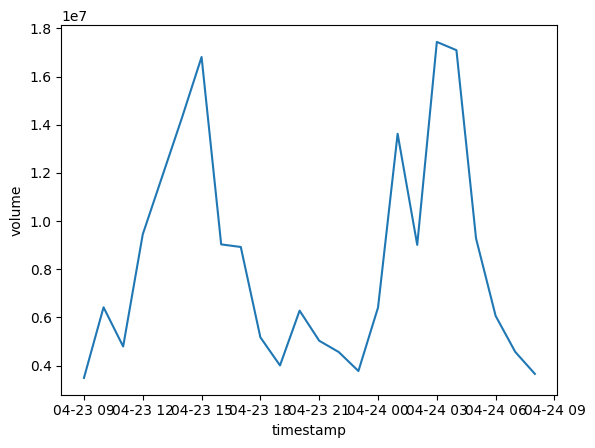

In [23]:
sns.lineplot(data=df, x='timestamp', y='volume', errorbar=None)

In [28]:
df[df['name'] == 'BTC/USDT'].describe()

,timestamp,open,high,low,close,volume
count,24,24.000000,24.000000,24.000000,24.000000,24.000000
mean,2024-04-23 20:30:00,66522.040833,66686.419167,66335.843750,66539.163750,888.962902
min,2024-04-23 09:00:00,66043.990000,66165.000000,65765.810000,66043.990000,178.632100
25%,2024-04-23 14:45:00,66352.705000,66461.940000,66104.747500,66360.372500,597.576842
50%,2024-04-23 20:30:00,66519.655000,66756.865000,66390.000000,66569.075000,762.428470
75%,2024-04-24 02:15:00,66744.275000,66887.760000,66585.457500,66744.277500,1041.086460
max,2024-04-24 08:00:00,67008.000000,67130.000000,66682.330000,67008.000000,2790.678300
std,NaN,270.075957,273.959017,265.098629,262.693296,544.527670
